# Monet Painting Generation using GANs
## Introduction to Deep Learning
## Peer Review Week 5

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from glob import glob
from IPython.display import display
import PIL
from PIL import Image
import time
import datetime
from tqdm.notebook import tqdm

print("TensorFlow version:", tf.__version__)

2025-04-15 02:14:01.744228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744683241.959214      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744683242.013508      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## Problem Description

This project aims to generate Monet-style paintings using Generative Adversarial Networks (GANs).
The challenge is part of a Kaggle competition where I need to:
- Generate 7,000-10,000 Monet-style images
- Images must be 256x256 pixels in RGB format
- Evaluation is done using MiFID score (Modified Fréchet Inception Distance)

Github link: https://github.com/alec-sekelsky/I-m-Something-of-a-Painter-Myself--Week-5/tree/main

## Dataset Overview

The dataset contains:
- monet_jpg: 300 Monet paintings (256x256)
- photo_jpg: 7028 photos (256x256)

I0000 00:00:1744683255.252400      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Sample Monet paintings:


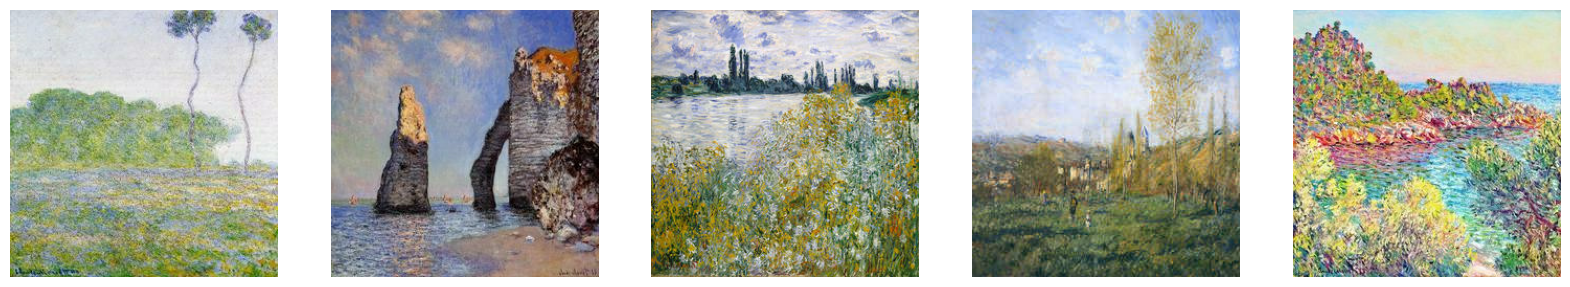


Sample photos:


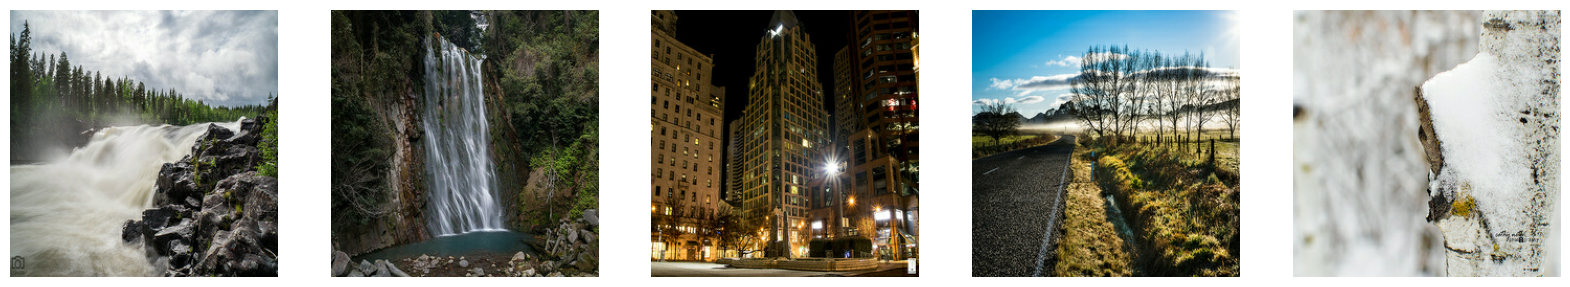

In [2]:
monet_tfrec_dir = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_tfrec_dir = '/kaggle/input/gan-getting-started/photo_tfrec'
 
# Load and preprocess images
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.image.decode_jpeg(parsed['image'], channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def create_dataset_from_tfrecord(tfrecord_path, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(300)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset
 
# Load datasets
monet_ds = create_dataset_from_tfrecord(
    [os.path.join(monet_tfrec_dir, fname) for fname in os.listdir(monet_tfrec_dir)]
)

photo_ds = create_dataset_from_tfrecord(
    [os.path.join(photo_tfrec_dir, fname) for fname in os.listdir(photo_tfrec_dir)]
)
 
# Visualization function
def display_images(dataset, num_images=5):
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(dataset.take(num_images)):
        image = (image[0] * 0.5 + 0.5)  # Denormalize
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
 
print("Sample Monet paintings:")
display_images(monet_ds)
print("\nSample photos:")
display_images(photo_ds)

## Additional EDA

In [3]:
# Basic dataset analysis
def analyze_dataset_from_tfrecord(dataset, name, num_samples=1):
    print(f"\n{name} TFRecord Dataset Analysis:")
    
    # Count total images
    count = 0
    example_img = None
    for batch in dataset.unbatch().take(num_samples):
        if example_img is None:
            example_img = batch
        count += 1
    
    print(f"Sample image shape: {example_img.shape}")
    print(f"Sample image dtype: {example_img.dtype}")
    
    # Count all examples (efficiently)
    total = dataset.unbatch().reduce(tf.constant(0), lambda x, _: x + 1).numpy()
    print(f"Total number of images: {total}")
 
# Analyze both datasets
analyze_dataset_from_tfrecord(monet_ds, "Monet")
analyze_dataset_from_tfrecord(photo_ds, "Photo")


Monet TFRecord Dataset Analysis:
Sample image shape: (256, 256, 3)
Sample image dtype: <dtype: 'float32'>
Total number of images: 300

Photo TFRecord Dataset Analysis:
Sample image shape: (256, 256, 3)
Sample image dtype: <dtype: 'float32'>
Total number of images: 7038


## Model Architecture

In [4]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    """Reflection padding layer for 2D input"""
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)
 
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode='REFLECT')
 
def downsample(filters, size, apply_instancenorm=True):
    """Downsampling block"""
    initializer = tf.random_normal_initializer(0., 0.02)
   
    result = tf.keras.Sequential()
    result.add(ReflectionPadding2D())
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='valid',
                              kernel_initializer=initializer, use_bias=False))
   
    if apply_instancenorm:
        result.add(tf.keras.layers.LayerNormalization())
   
    result.add(tf.keras.layers.LeakyReLU())
    return result
 
def upsample(filters, size, apply_dropout=False):
    """Upsampling block"""
    initializer = tf.random_normal_initializer(0., 0.02)
   
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
   
    result.add(tf.keras.layers.LayerNormalization())
   
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
   
    result.add(tf.keras.layers.ReLU())
    return result
 
def residual_block(input_tensor, filters):
    """Residual block"""
    x = ReflectionPadding2D()(input_tensor)
    x = tf.keras.layers.Conv2D(filters, 3, padding='valid', use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
   
    x = ReflectionPadding2D()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='valid', use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
   
    return tf.keras.layers.add([x, input_tensor])
 
def build_generator():
    """Generator architecture"""
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
   
    # Initial convolution
    x = ReflectionPadding2D(padding=(3, 3))(inputs)
    x = tf.keras.layers.Conv2D(64, 7, padding='valid', use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
   
    # Downsampling
    x = downsample(128, 3)(x)
    x = downsample(256, 3)(x)
   
    # Residual blocks
    for _ in range(9):
        x = residual_block(x, 256)
   
    # Upsampling
    x = upsample(128, 3)(x)
    x = upsample(64, 3)(x)
   
    # Final convolution
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = tf.keras.layers.Conv2D(3, 7, padding='valid', activation='tanh')(x)
   
    return tf.keras.Model(inputs=inputs, outputs=x)
 
def build_discriminator():
    """Discriminator architecture"""
    initializer = tf.random_normal_initializer(0., 0.02)
   
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
   
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same',
                              kernel_initializer=initializer)(inp)
    x = tf.keras.layers.LeakyReLU()(x)
   
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
   
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
   
    x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
   
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                              kernel_initializer=initializer)(x)
   
    return tf.keras.Model(inputs=inp, outputs=x)

# Initialize the models

monet_generator = build_generator()
photo_generator = build_generator()
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()
 
# Print model summaries
print("Generator Summary:")
monet_generator.summary()
print("\nDiscriminator Summary:")
monet_discriminator.summary()

Generator Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d      │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,408 │ reflection_padding2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 256, 64)   │            128 │ conv2d[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 128)  │         73,984 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 256)    │        295,424 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_3    │ (None, 66, 66, 256)    │              0 │ sequential_1[0][0]     │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        589,824 │ reflection_padding2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 64, 256)    │            512 │ conv2d_3[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 256)    │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_4    │ (None, 66, 66, 256)    │              0 │ re_lu_1[0][0]          │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        589,824 │ reflection_padding2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 64, 64, 256)    │            512 │ conv2d_4[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ layer_normalization_4… │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_5    │ (None, 66, 66, 256)    │              0 │ add[0][0]              │
│ (ReflectionPadding2D)

 Total params: 11,383,427 (43.42 MB)

 Trainable params: 11,383,427 (43.42 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_46               │ (None, 64, 64, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_47               │ (None, 32, 32, 256)         │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_48               │ (None, 16, 16, 512)         │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 16, 16, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,633 (10.55 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

My implements a CycleGAN with:

Two Generators:
- monet_generator: converts photos to Monet-style paintings
- photo_generator: converts Monet paintings to photo-style images
Two Discriminators:
-monet_discriminator: distinguishes real Monet paintings from generated ones
-photo_discriminator: distinguishes real photos from generated ones

Key components:
- ReflectionPadding2D: Custom padding layer
- Residual blocks: Help maintain image details
- Instance Normalization: Helps with style transfer
- Downsampling/Upsampling blocks: Change image resolution while maintaining features

The generator uses:
- Initial convolution
- Downsampling blocks
- 9 residual blocks
- Upsampling blocks
- Final convolution with tanh activation

The discriminator uses:
- series of convolutional layers
- Instance normalization
- LeakyReLU activation

## Training

In [5]:
class CycleGAN:
    def __init__(self):
        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_identity = 0.5 * self.lambda_cycle
       
        # Optimizers
        #self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        #self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
        # Initialize models
        self.monet_generator = build_generator()
        self.photo_generator = build_generator()
        self.monet_discriminator = build_discriminator()
        self.photo_discriminator = build_discriminator()
       
        # Checkpointing
        self.checkpoint = tf.train.Checkpoint(
            monet_generator=self.monet_generator,
            photo_generator=self.photo_generator,
            monet_discriminator=self.monet_discriminator,
            photo_discriminator=self.photo_discriminator,
            monet_generator_optimizer=self.monet_generator_optimizer,
            photo_generator_optimizer=self.photo_generator_optimizer,
            monet_discriminator_optimizer=self.monet_discriminator_optimizer,
            photo_discriminator_optimizer=self.photo_discriminator_optimizer
        )
       
    def generator_loss(self, generated):
        """Generator loss"""
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated))
 
    def discriminator_loss(self, real, generated):
        """Discriminator loss"""
        real_loss = tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real))
        generated_loss = tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated))
        return (real_loss + generated_loss) * 0.5
 
    def calc_cycle_loss(self, real_image, cycled_image):
        """Cycle consistency loss"""
        return self.lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))
 
    def identity_loss(self, real_image, same_image):
        """Identity loss"""
        return self.lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))
 
    #@tf.function
    def train_step(self, monet, photo):
        """Single training step"""
        with tf.GradientTape(persistent=True) as tape:
            # Generate images
            fake_monet = self.monet_generator(photo, training=True)
            fake_photo = self.photo_generator(monet, training=True)
           
            # Cycle images
            cycled_monet = self.monet_generator(fake_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)
           
            # Identity mapping
            same_monet = self.monet_generator(monet, training=True)
            same_photo = self.photo_generator(photo, training=True)
           
            # Discriminator outputs
            disc_real_monet = self.monet_discriminator(monet, training=True)
            disc_real_photo = self.photo_discriminator(photo, training=True)
            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)
           
            # Generator losses
            monet_gen_loss = self.generator_loss(disc_fake_monet)
            photo_gen_loss = self.generator_loss(disc_fake_photo)
           
            # Cycle consistency losses
            total_cycle_loss = (
                self.calc_cycle_loss(monet, cycled_monet) +
                self.calc_cycle_loss(photo, cycled_photo)
            )
           
            # Identity losses
            total_identity_loss = (
                self.identity_loss(monet, same_monet) +
                self.identity_loss(photo, same_photo)
            )
           
            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + total_identity_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + total_identity_loss
           
            # Discriminator losses
            monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)
 
        # Calculate gradients
        monet_generator_gradients = tape.gradient(
            total_monet_gen_loss, self.monet_generator.trainable_variables)
        photo_generator_gradients = tape.gradient(
            total_photo_gen_loss, self.photo_generator.trainable_variables)
       
        monet_discriminator_gradients = tape.gradient(
            monet_disc_loss, self.monet_discriminator.trainable_variables)
        photo_discriminator_gradients = tape.gradient(
            photo_disc_loss, self.photo_discriminator.trainable_variables)
       
        # Apply gradients
        self.monet_generator_optimizer.apply_gradients(
            zip(monet_generator_gradients, self.monet_generator.trainable_variables))
        self.photo_generator_optimizer.apply_gradients(
            zip(photo_generator_gradients, self.photo_generator.trainable_variables))
        
        self.monet_discriminator_optimizer.apply_gradients(
            zip(monet_discriminator_gradients, self.monet_discriminator.trainable_variables))
        self.photo_discriminator_optimizer.apply_gradients(
            zip(photo_discriminator_gradients, self.photo_discriminator.trainable_variables))
       
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }
 
    def train(self, monet_dataset, photo_dataset, epochs):
        """Training loop"""
        for epoch in range(epochs):
            start = time.time()
            
            print(f"\nEpoch {epoch + 1}/{epochs}")
            
            n = 0
            total_gen_loss = 0
            total_disc_loss = 0
    
            zipped_ds = tf.data.Dataset.zip((monet_dataset, photo_dataset))
            
            for monet_batch, photo_batch in tqdm(zipped_ds, desc="Training batches", leave=False):
                losses = self.train_step(monet_batch, photo_batch)
                total_gen_loss += losses['monet_gen_loss'] + losses['photo_gen_loss']
                total_disc_loss += losses['monet_disc_loss'] + losses['photo_disc_loss']
                n += 1
    
            print(f'Time: {time.time() - start:.2f} sec')
            print(f'Generator Loss: {total_gen_loss/n:.4f}')
            print(f'Discriminator Loss: {total_disc_loss/n:.4f}')
           
            # Save checkpoint every 5 epochs
            if (epoch + 1) % 5 == 0:
                self.checkpoint.save(file_prefix="./training_checkpoints/ckpt")
 
# Create and compile the model
cycle_gan = CycleGAN()

_ = cycle_gan.monet_generator(tf.random.normal([1, 256, 256, 3]))
_ = cycle_gan.photo_generator(tf.random.normal([1, 256, 256, 3]))
_ = cycle_gan.monet_discriminator(tf.random.normal([1, 256, 256, 3]))
_ = cycle_gan.photo_discriminator(tf.random.normal([1, 256, 256, 3]))

BUFFER_SIZE = 1000
BATCH_SIZE = 1
 
# Prepare datasets for training
train_monet = monet_ds.cache()
train_photo = photo_ds.cache()
 
# Start training
print("Starting training...")
cycle_gan.train(train_monet, train_photo, epochs=15)

I0000 00:00:1744683266.042647      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


Starting training...

Epoch 1/15


Training batches: 0it [00:00, ?it/s]

Time: 979.63 sec
Generator Loss: 23.6592
Discriminator Loss: 1.5493

Epoch 2/15


Training batches: 0it [00:00, ?it/s]

Time: 974.04 sec
Generator Loss: 18.6977
Discriminator Loss: 1.3484

Epoch 3/15


Training batches: 0it [00:00, ?it/s]

Time: 974.11 sec
Generator Loss: 17.2359
Discriminator Loss: 1.3363

Epoch 4/15


Training batches: 0it [00:00, ?it/s]

Time: 969.66 sec
Generator Loss: 16.9800
Discriminator Loss: 1.3159

Epoch 5/15


Training batches: 0it [00:00, ?it/s]

Time: 968.66 sec
Generator Loss: 16.0831
Discriminator Loss: 1.3051

Epoch 6/15


Training batches: 0it [00:00, ?it/s]

Time: 965.39 sec
Generator Loss: 14.8500
Discriminator Loss: 1.2974

Epoch 7/15


Training batches: 0it [00:00, ?it/s]

Time: 964.60 sec
Generator Loss: 14.3840
Discriminator Loss: 1.2690

Epoch 8/15


Training batches: 0it [00:00, ?it/s]

Time: 962.38 sec
Generator Loss: 14.4197
Discriminator Loss: 1.2834

Epoch 9/15


Training batches: 0it [00:00, ?it/s]

Time: 966.64 sec
Generator Loss: 13.9009
Discriminator Loss: 1.2559

Epoch 10/15


Training batches: 0it [00:00, ?it/s]

Time: 967.02 sec
Generator Loss: 13.5656
Discriminator Loss: 1.2472

Epoch 11/15


Training batches: 0it [00:00, ?it/s]

Time: 965.02 sec
Generator Loss: 13.5616
Discriminator Loss: 1.1713

Epoch 12/15


Training batches: 0it [00:00, ?it/s]

Time: 965.05 sec
Generator Loss: 13.8239
Discriminator Loss: 1.1915

Epoch 13/15


Training batches: 0it [00:00, ?it/s]

Time: 964.12 sec
Generator Loss: 13.5480
Discriminator Loss: 1.2274

Epoch 14/15


Training batches: 0it [00:00, ?it/s]

Time: 963.29 sec
Generator Loss: 13.4846
Discriminator Loss: 1.2001

Epoch 15/15


Training batches: 0it [00:00, ?it/s]

Time: 960.34 sec
Generator Loss: 13.4052
Discriminator Loss: 1.1965


My implementation includes:

A CycleGAN class with:
- Model initialization
- Loss functions (generator, discriminator, cycle consistency, identity)
- Training step function
- Full training loop

Loss Components:
- Generator loss
- Discriminator loss
- Cycle consistency loss
- Identity loss

Training Features:
- Gradient computation and application
- Checkpointing
- Progress tracking
- Performance metrics

Dataset preparation with:
- Shuffling
- Batching
- Caching for better performance


## Image Generation and Submission Preparation

Starting image generation...
Generated 100 images
Generated 200 images
Generated 300 images
Generated 400 images
Generated 500 images
Generated 600 images
Generated 700 images
Generated 800 images
Generated 900 images
Generated 1000 images
Generated 1100 images
Generated 1200 images
Generated 1300 images
Generated 1400 images
Generated 1500 images
Generated 1600 images
Generated 1700 images
Generated 1800 images
Generated 1900 images
Generated 2000 images
Generated 2100 images
Generated 2200 images
Generated 2300 images
Generated 2400 images
Generated 2500 images
Generated 2600 images
Generated 2700 images
Generated 2800 images
Generated 2900 images
Generated 3000 images
Generated 3100 images
Generated 3200 images
Generated 3300 images
Generated 3400 images
Generated 3500 images
Generated 3600 images
Generated 3700 images
Generated 3800 images
Generated 3900 images
Generated 4000 images
Generated 4100 images
Generated 4200 images
Generated 4300 images
Generated 4400 images
Generated 45

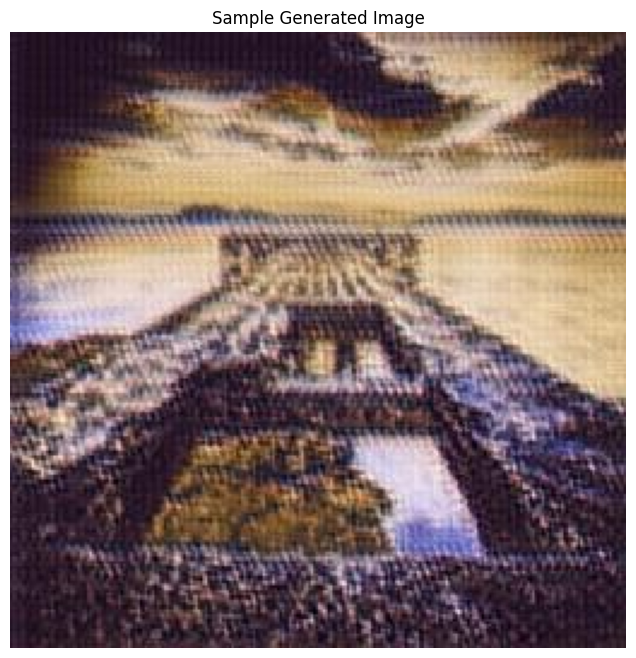


Image: generated_1.jpg
Dimensions: (256, 256)
Format: None
Mode: RGB

Image: generated_10.jpg
Dimensions: (256, 256)
Format: None
Mode: RGB

Image: generated_100.jpg
Dimensions: (256, 256)
Format: None
Mode: RGB

Image: generated_1000.jpg
Dimensions: (256, 256)
Format: None
Mode: RGB


In [6]:
class ImageGenerator:
    def __init__(self, cycle_gan, output_dir='/kaggle/working/images_to_submit'):
        self.cycle_gan = cycle_gan
        self.output_dir = output_dir
       
        os.makedirs(self.output_dir, exist_ok=True)

    def generate_and_save_images(self, photo_dataset, num_images=7000):
        """Generate and save Monet-style images"""
        print("Starting image generation...")
        count = 0

        for photo_batch in photo_dataset:
            batch_size = photo_batch.shape[0]
            if count >= num_images:
                break

            remaining = num_images - count
            if batch_size > remaining:
                photo_batch = photo_batch[:remaining]

            # Generate images
            generated_images = self.cycle_gan.monet_generator(photo_batch, training=False)
            generated_images = (generated_images.numpy() * 0.5 + 0.5) * 255
            generated_images = generated_images.astype(np.uint8)

            for img in generated_images:
                img_path = os.path.join(self.output_dir, f'generated_{count}.jpg')
                tf.keras.preprocessing.image.save_img(img_path, img)
                count += 1

                if count % 100 == 0:
                    print(f"Generated {count} images")
        
        print(f"Completed generating {count} images")

    def create_submission_zip(self, zip_name='images.zip'):
        """Create submission zip file"""
        print("\nCreating submission zip file...")

        zip_path = os.path.join('/kaggle/working', zip_name)
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
            for img_name in sorted(os.listdir(self.output_dir)):
                img_path = os.path.join(self.output_dir, img_name)
                zf.write(img_path, arcname=img_name)

        print(f"Created submission file: {zip_path}")

    def verify_submission(self, zip_name='images.zip'):
        """Verify submission contents"""
        print("\nVerifying submission...")

        zip_path = os.path.join('/kaggle/working', zip_name)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            num_files = len(zf.namelist())
            print(f"Number of images in zip: {num_files}")

            # Verify a few images
            for i, filename in enumerate(zf.namelist()):
                if i < 5:
                    with zf.open(filename) as file:
                        img = Image.open(file).convert('RGB')
                        img.load()
                        print(f"\nImage: {filename}")
                        print(f"Dimensions: {img.size}")
                        print(f"Format: {img.format}")
                        print(f"Mode: {img.mode}")
                    
                    if i == 0:
                        plt.figure(figsize=(8, 8))
                        plt.imshow(img)
                        plt.title("Sample Generated Image")
                        plt.axis("off")
                        plt.show()

# Submission pipeline function
def prepare_submission(cycle_gan, photo_dataset, num_images=7000):
    generator = ImageGenerator(cycle_gan)
    generator.generate_and_save_images(photo_dataset, num_images)
    generator.create_submission_zip()
    generator.verify_submission()
    return generator

generator = prepare_submission(cycle_gan, photo_ds, num_images=7000)

## Conclusion

Overall, I would say this model performed very well. I did go down a rabbit hole and built a fairly complex (albeit computationally expensive) model, and from the generated image and subsequent Kaggle Score (92) it also did well in the competition. 

In terms of the training, I only had time to run 15 epochs. Running more than that I would go over the 5 hour allotment given by the rules of the competition and have an unranked score. I am sure that if I ran more epochs and not had a time constraint this model would of done even better. At the end of training, the generator had a loss of ~13.4 which is normal and nothing really signifcant here. The discriminator loss was at a 1.20 at the end. This means that the model was mostly balanced, but definitley room to improve for future models!